In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np


In [3]:
import pandas as pd

emicron = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/Final_Project/Data/emicron_clean.csv")  # Include the subdirectory in the file path

#Remove non-numeric columns, scale and apply PCA

In [4]:
from sklearn.preprocessing import StandardScaler

# Filter columns based on data types
numeric_columns = emicron.select_dtypes(include=['int64', 'float64'])

# Create a new DataFrame with only numeric columns
emicron = emicron[numeric_columns.columns]

# Now you can scale the data
scaler = StandardScaler()
X = scaler.fit_transform(emicron)

In [5]:
from sklearn.decomposition import PCA

# Apply PCA and keep only the top components

pca = PCA(n_components=10)

X = pca.fit_transform(X)

In [6]:
X.shape

(85862, 10)

#Models: HAC

In [ ]:
X_sample = X[(np.random.choice(X.shape[0], size=5000, replace=False))]

In [ ]:
from sklearn.cluster import AgglomerativeClustering

# Saving a shorter named object to use
HClust = AgglomerativeClustering

# Fitting a model
hc_comp = HClust(distance_threshold=0,
                 n_clusters=None,
                 linkage='ward')

# Fitting this to our data
hc_comp.fit(X_sample)

AgglomerativeClustering(distance_threshold=0, n_clusters=None)

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

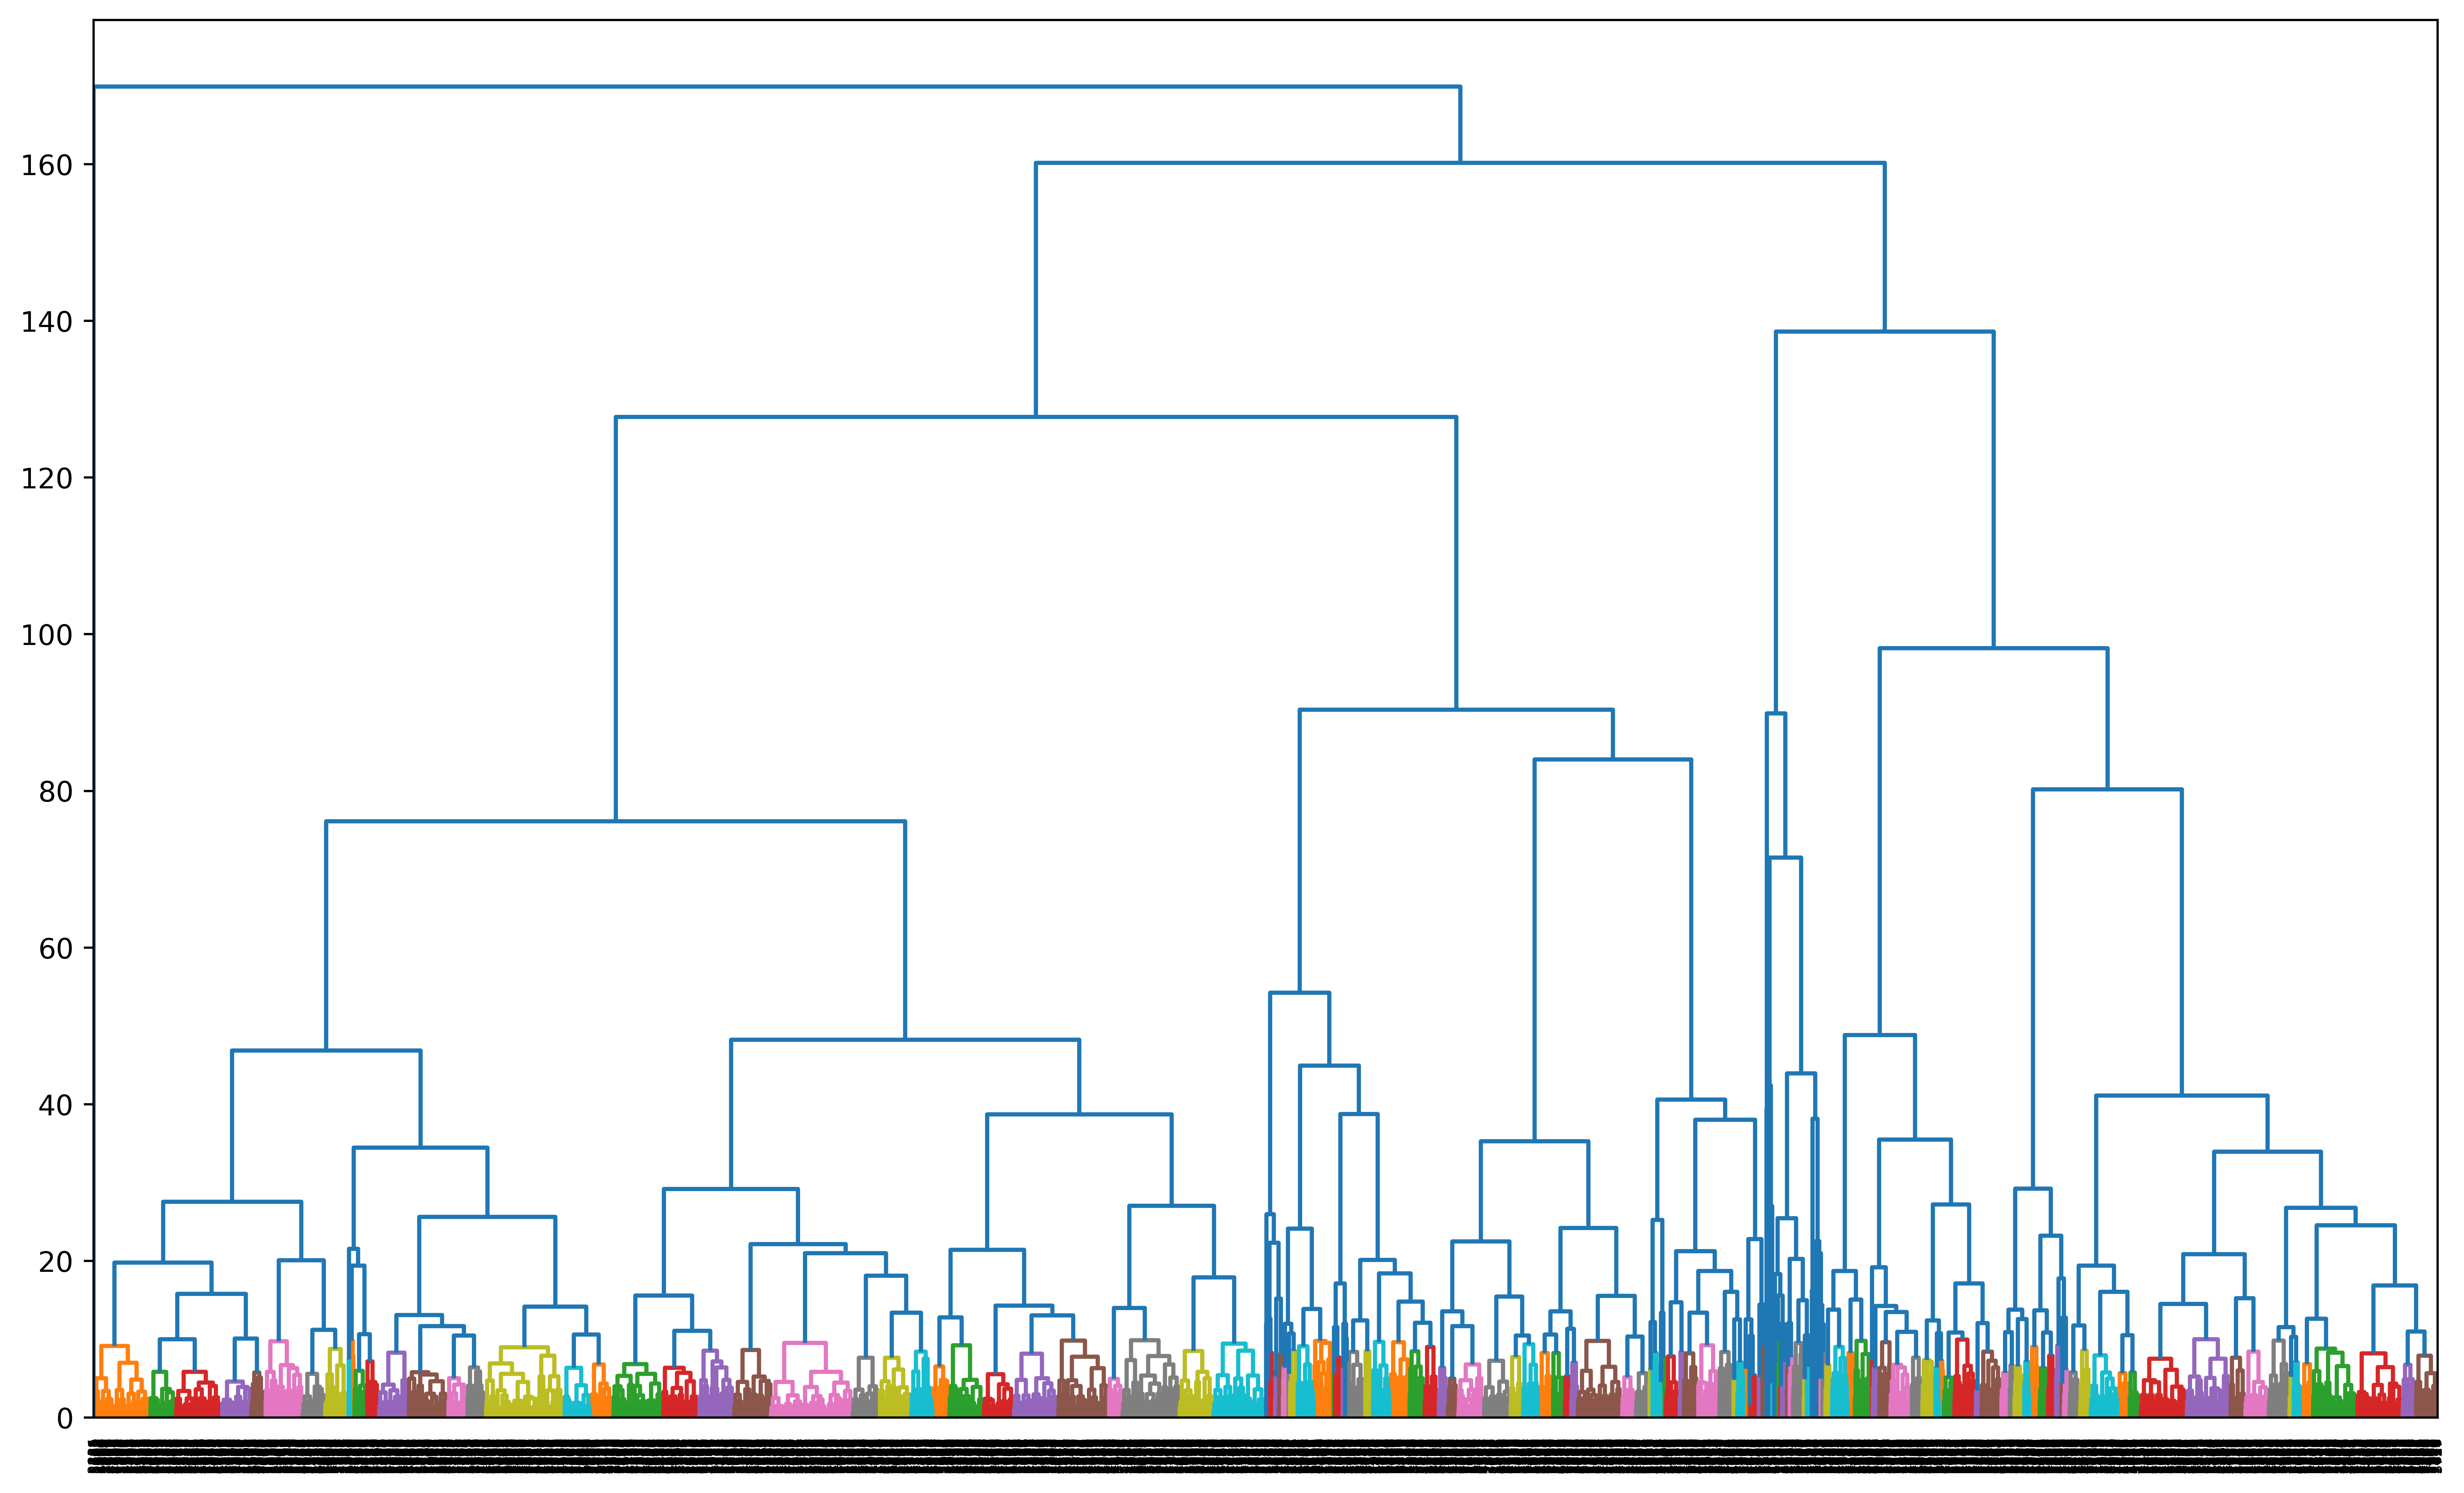

In [ ]:
import matplotlib.pyplot as plt

# Create a linkage matrix using the scipy.cluster function, this calculates the order of the groups
Z = linkage(X_sample, method='ward')

color_threshold = 10  # Adjust the vertical threshold for assigning groups / clusters
plt.figure(figsize=(15, 9), dpi=600) # altering the figure size and resolution with dpi
dendrogram(Z, color_threshold=color_threshold)
# Rotate the x-axis labels for better readability
plt.xticks(rotation=90)
# Show the plot
plt.show()

#Models: K-Means

In [7]:
from sklearn.cluster import KMeans

# There appears to be an elbow around a value of 8. We can refit a model with this value and see what the groups look like
kmeans_elbow = KMeans(n_clusters=8, n_init=20, random_state=0)

# Fitting and predicting in one line
y_pred_elbow = kmeans_elbow.fit_predict(X)

In [8]:
# Storing the predictions in a dataframe to work with
kmeans_pred = pd.DataFrame(
    {'pred_cluster': y_pred_elbow},
    index=emicron.index
)

In [9]:
# Examining the cluster groupings
kmeans_pred.pred_cluster.value_counts()

0    29389
1    24147
3    11917
5    10444
4     8204
2     1694
6       63
7        4
Name: pred_cluster, dtype: int64

In [10]:
#looking into cluster 0
kmeans_pred.query('pred_cluster==0')

,pred_cluster
0,0
1,0
2,0
4,0
5,0
...,...
85845,0
85847,0
85848,0
85849,0


In [11]:
from sklearn.metrics import silhouette_score

In [ ]:
k_range = list(range(2, 20+1))

# Empty list to hold the inertia values
inertias = []
silhouettes = []

for k in k_range:
    # Fit the model
    kmeans_loop = KMeans(n_clusters=k, n_init=10, random_state=0)
    kmeans_loop.fit(X)

    # Save the inertia
    inertias.append(kmeans_loop.inertia_)
    silhouettes.append(silhouette_score(X, kmeans_loop.labels_))